In [1]:
!pip install torchmetrics

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from torch.optim.lr_scheduler import StepLR  # Import the learning rate scheduler
from tqdm import tqdm  # Import tqdm for progress bars

# Path to your dataset
ground_truth_path = "/kaggle/input/ellipses-fullangle-128x128-4000/ground_truth_128dim_4000sz.pt"
recon_ellipses_path = "/kaggle/input/ellipses-fullangle-128x128-4000/recon_ellipses_128dim_4000s.pt"

# Load the datasets
ground_truth_images = torch.load(ground_truth_path)
reconstructed_images = torch.load(recon_ellipses_path)
ground_truth_images = ground_truth_images.view(-1, 1, 128, 128)
reconstructed_images = reconstructed_images.view(-1, 1, 128, 128)

# Create a TensorDataset
dataset = TensorDataset(reconstructed_images, ground_truth_images)

# Split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)


In [5]:
import torch
from torch import nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        self.double_conv = DoubleConv(in_channels, out_channels)  # No change needed here since DoubleConv adjusts automatically
        self.down_sample = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identity = self.downsample(x)
        out = self.double_conv(x)
        out = self.relu(out + identity)
        return self.down_sample(out), out
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        # input is CHW
        diffY = skip_input.size()[2] - x.size()[2]
        diffX = skip_input.size()[3] - x.size()[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class ResUNet(nn.Module):
    """
    Hybrid solution of resnet blocks and double conv blocks
    Modified to work with 1-channel (grayscale) input images.
    """
    def __init__(self, out_classes=2):
        super(ResUNet, self).__init__()
    
        self.down_conv1 = ResBlock(1, 64)  # Adjusted to accept 1-channel input
        self.down_conv2 = ResBlock(64, 128)
        self.down_conv3 = ResBlock(128, 256)
        self.down_conv4 = ResBlock(256, 512)
    
        self.double_conv = DoubleConv(512, 1024)
    
        self.up_conv4 = UpBlock(512 + 1024, 512)
        self.up_conv3 = UpBlock(256 + 512, 256)
        self.up_conv2 = UpBlock(128 + 256, 128)
        self.up_conv1 = UpBlock(128 + 64, 64)
    
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
    
    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResUNet(out_classes=1).to(device)  # Correct model instantiation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

# Training loop
num_epochs = 20
training_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())

    scheduler.step()  # Update the learning rate
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

torch.save(model.state_dict(), 'residual_unet.pth')

  5%|▌         | 1/20 [00:26<08:26, 26.66s/it]

Epoch [1/20], Loss: 0.004392


 10%|█         | 2/20 [00:52<07:50, 26.11s/it]

Epoch [2/20], Loss: 0.003417


 15%|█▌        | 3/20 [01:18<07:20, 25.94s/it]

Epoch [3/20], Loss: 0.001706


 20%|██        | 4/20 [01:43<06:53, 25.86s/it]

Epoch [4/20], Loss: 0.001995


 25%|██▌       | 5/20 [02:09<06:27, 25.82s/it]

Epoch [5/20], Loss: 0.002857


 30%|███       | 6/20 [02:35<06:01, 25.79s/it]

Epoch [6/20], Loss: 0.001050


 35%|███▌      | 7/20 [03:01<05:35, 25.77s/it]

Epoch [7/20], Loss: 0.001462


 40%|████      | 8/20 [03:26<05:09, 25.76s/it]

Epoch [8/20], Loss: 0.000760


 45%|████▌     | 9/20 [03:52<04:43, 25.75s/it]

Epoch [9/20], Loss: 0.001227


 50%|█████     | 10/20 [04:18<04:17, 25.75s/it]

Epoch [10/20], Loss: 0.000620


 55%|█████▌    | 11/20 [04:44<03:51, 25.75s/it]

Epoch [11/20], Loss: 0.000784


 60%|██████    | 12/20 [05:09<03:25, 25.74s/it]

Epoch [12/20], Loss: 0.001173


 65%|██████▌   | 13/20 [05:35<03:00, 25.74s/it]

Epoch [13/20], Loss: 0.000786


 70%|███████   | 14/20 [06:01<02:34, 25.74s/it]

Epoch [14/20], Loss: 0.001087


 75%|███████▌  | 15/20 [06:26<02:08, 25.74s/it]

Epoch [15/20], Loss: 0.000471


 80%|████████  | 16/20 [06:52<01:42, 25.74s/it]

Epoch [16/20], Loss: 0.000320


 85%|████████▌ | 17/20 [07:18<01:17, 25.74s/it]

Epoch [17/20], Loss: 0.000823


 90%|█████████ | 18/20 [07:44<00:51, 25.74s/it]

Epoch [18/20], Loss: 0.000604


 95%|█████████▌| 19/20 [08:09<00:25, 25.74s/it]

Epoch [19/20], Loss: 0.000558


100%|██████████| 20/20 [08:35<00:00, 25.78s/it]

Epoch [20/20], Loss: 0.000408


Average SSIM: 0.9812
Average PSNR: 38.1232
Average SSIM: 0.8890
Average PSNR: 26.4424


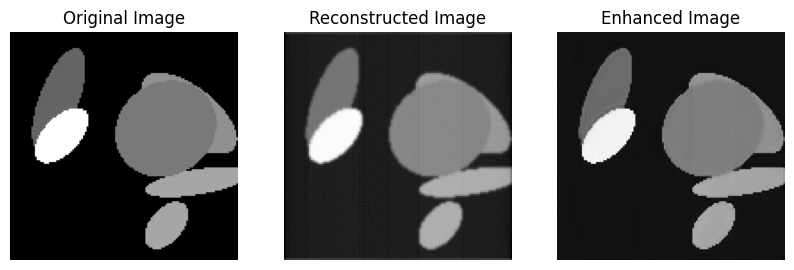

In [7]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate SSIM for a batch of images
def batch_ssim(enhanced_images, ground_truth_images):
    ssim_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = ssim(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Function to calculate PSNR for a batch of images
def batch_psnr(enhanced_images, ground_truth_images):
    psnr_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = psnr(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in test_loader:
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {rec_ssim:.4f}')
print(f'Average PSNR: {rec_psnr:.4f}')